In [15]:
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [19]:
!unzip '/content/drive/MyDrive/Dataset-20230701T024738Z-001.zip'

Archive:  /content/drive/MyDrive/Dataset-20230701T024738Z-001.zip
  inflating: Dataset/annotations_prepped_test/0016E5_08103.png  
  inflating: Dataset/annotations_prepped_test/0016E5_08141.png  
  inflating: Dataset/annotations_prepped_test/0016E5_07963.png  
  inflating: Dataset/images_prepped_test/0016E5_08071.png  
  inflating: Dataset/annotations_prepped_test/0016E5_08097.png  
  inflating: Dataset/annotations_prepped_test/0016E5_08025.png  
  inflating: Dataset/images_prepped_test/0016E5_07979.png  
  inflating: Dataset/images_prepped_test/0016E5_08043.png  
  inflating: Dataset/annotations_prepped_test/0016E5_08109.png  
  inflating: Dataset/annotations_prepped_test/0016E5_08151.png  
  inflating: Dataset/annotations_prepped_test/0016E5_08119.png  
  inflating: Dataset/images_prepped_test/0016E5_08051.png  
  inflating: Dataset/annotations_prepped_test/0016E5_08159.png  
  inflating: Dataset/annotations_prepped_test/0016E5_08011.png  
  inflating: Dataset/annotations_prepped_tes

#### Import Library

In [20]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
import torch
import torch.nn as nn
import keras.backend as K

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose, Cropping2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Metric
from keras.optimizers import Adam
from keras.losses import binary_crossentropy

import warnings
warnings.filterwarnings('ignore')

#### Load Dataset

In [21]:
# dataset path
ROOT_DATASET = '/content/Dataset'
os.listdir(ROOT_DATASET)

['images_prepped_test',
 'annotations_prepped_test',
 'images_prepped_train',
 'annotations_prepped_train']

In [22]:
img_path = ROOT_DATASET + '/images_prepped_train/'
annot_path = ROOT_DATASET + '/annotations_prepped_train/'
img_path_test = ROOT_DATASET + '/images_prepped_test/'
annot_path_test = ROOT_DATASET + '/annotations_prepped_test/'

In [23]:
train_images_dir = glob.glob(img_path+'/*.png')
train_annotations_dir = glob.glob(annot_path+'/*.png')
test_images_dir = glob.glob(img_path_test+'/*.png')
test_annotations_dir = glob.glob(annot_path_test+'/*.png')

In [24]:
IMAGE_SIZE = 224 #Change from 416

In [25]:
# data train
train_images = []
for img in train_images_dir:
    n = cv2.imread(img) #load image menggunakan opencv BGR
    x = cv2.resize(n, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
    train_images.append(x)
train_annotations = []
for img in train_annotations_dir:
    n = cv2.imread(img)
    x = cv2.resize(n, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
    train_annotations.append(x)

In [26]:
# data test
test_images = []
for img in test_images_dir:
    n = cv2.imread(img)
    x = cv2.resize(n, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
    test_images.append(x)
test_annotations = []
for img in test_annotations_dir:
    n = cv2.imread(img)
    x = cv2.resize(n, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
    test_annotations.append(x)

In [27]:
def changeToRGB(train_images_dir):
  result = []
  for img_gray in train_images_dir:
      n = cv2.imread(img_gray)
      gray_img = cv2.cvtColor(n, cv2.COLOR_BGR2RGB)
      x = cv2.resize(gray_img, (IMAGE_SIZE, IMAGE_SIZE)) # Resize to (224, 224)
      result.append(x)

  # Convert the gray_dataset list back to numpy array
  result = np.array(result)

  return result

In [28]:
def get_colored_segmentation_image(seg, colors,
                                    n_classes):
    """ Return a colored segmented image """
    seg_img = np.zeros_like(seg)

    for c in range(n_classes):
        seg_img[:, :, 0] += ((seg[:, :, 0] == c)
                             * (colors[c][0])).astype('uint8')
        seg_img[:, :, 1] += ((seg[:, :, 0] == c)
                             * (colors[c][1])).astype('uint8')
        seg_img[:, :, 2] += ((seg[:, :, 0] == c)
                             * (colors[c][2])).astype('uint8')
    return seg_img

# initiate fix colors list
class_colors = [(128,0,0), (170,110, 40), (128,128,0), (0,128,128), (0,0,128), (230,25,75), (245,130,48), (255,255,25), (210,245,60), (240,50,230),
               (128,128,128), (220,190,255), (255,215,180), (70,140,240), (0,130,200)]

In [29]:
plt.style.use('dark_background')

plt.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "white",
    "axes.facecolor": "black",
    "axes.edgecolor": "white",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "grey",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black"})

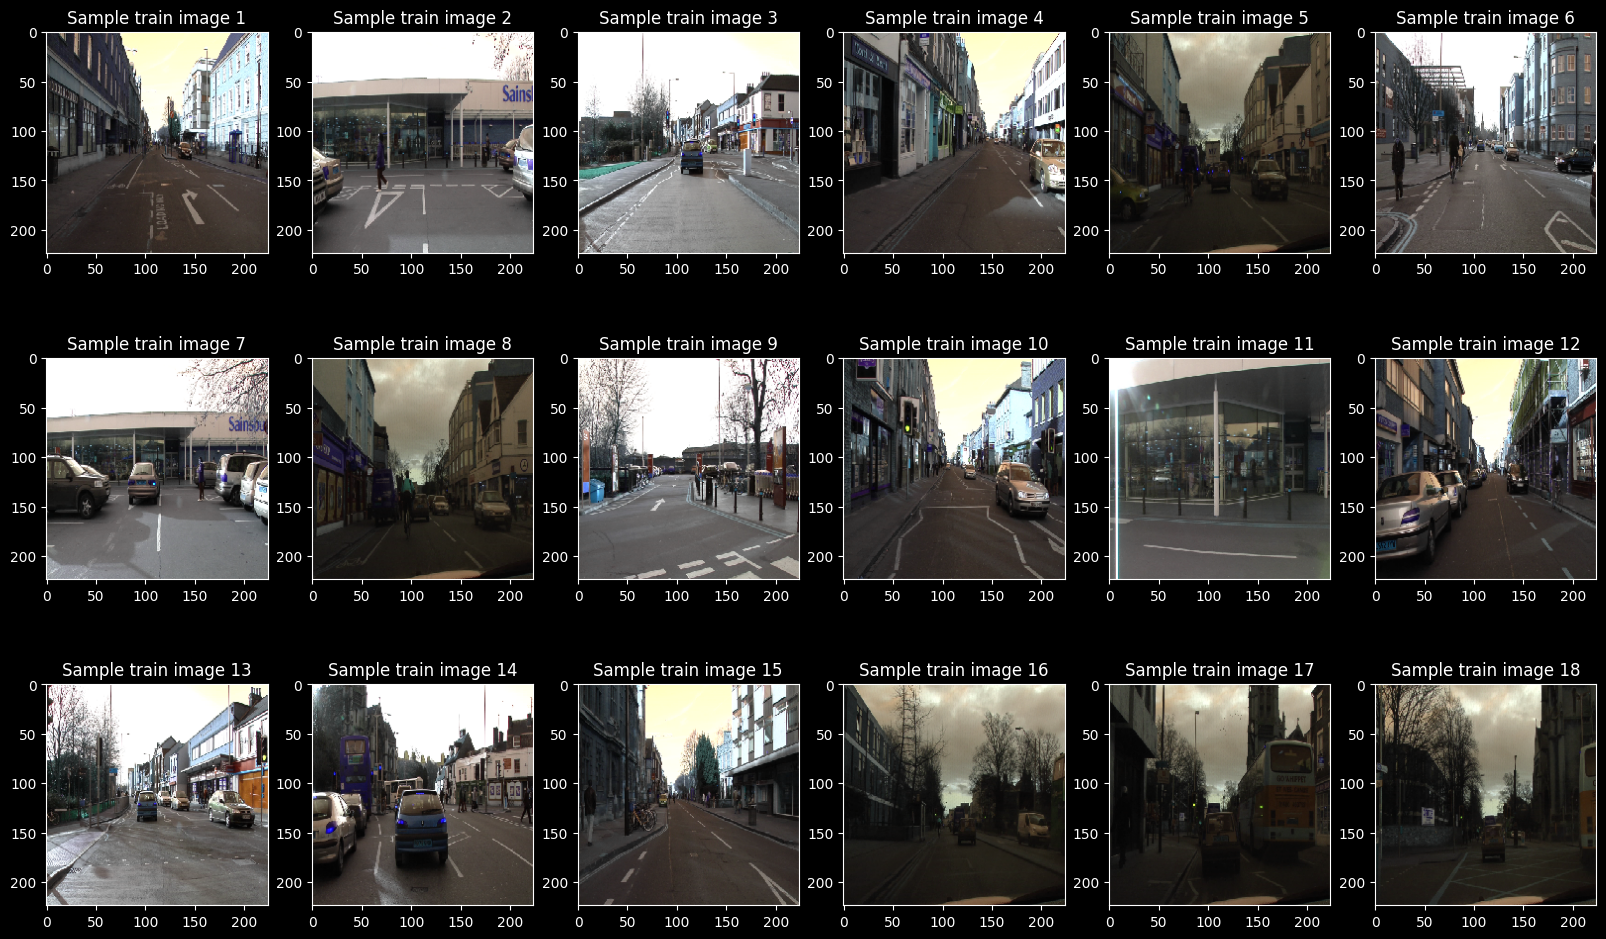

In [30]:
#Plot sample of train images
fig = plt.figure(figsize = (20,12))

for index in range(18):
    ax = fig.add_subplot(3,6,index+1)
    ax.set_title("Sample train image {}".format(index+1))
    ax.imshow(train_images[index])

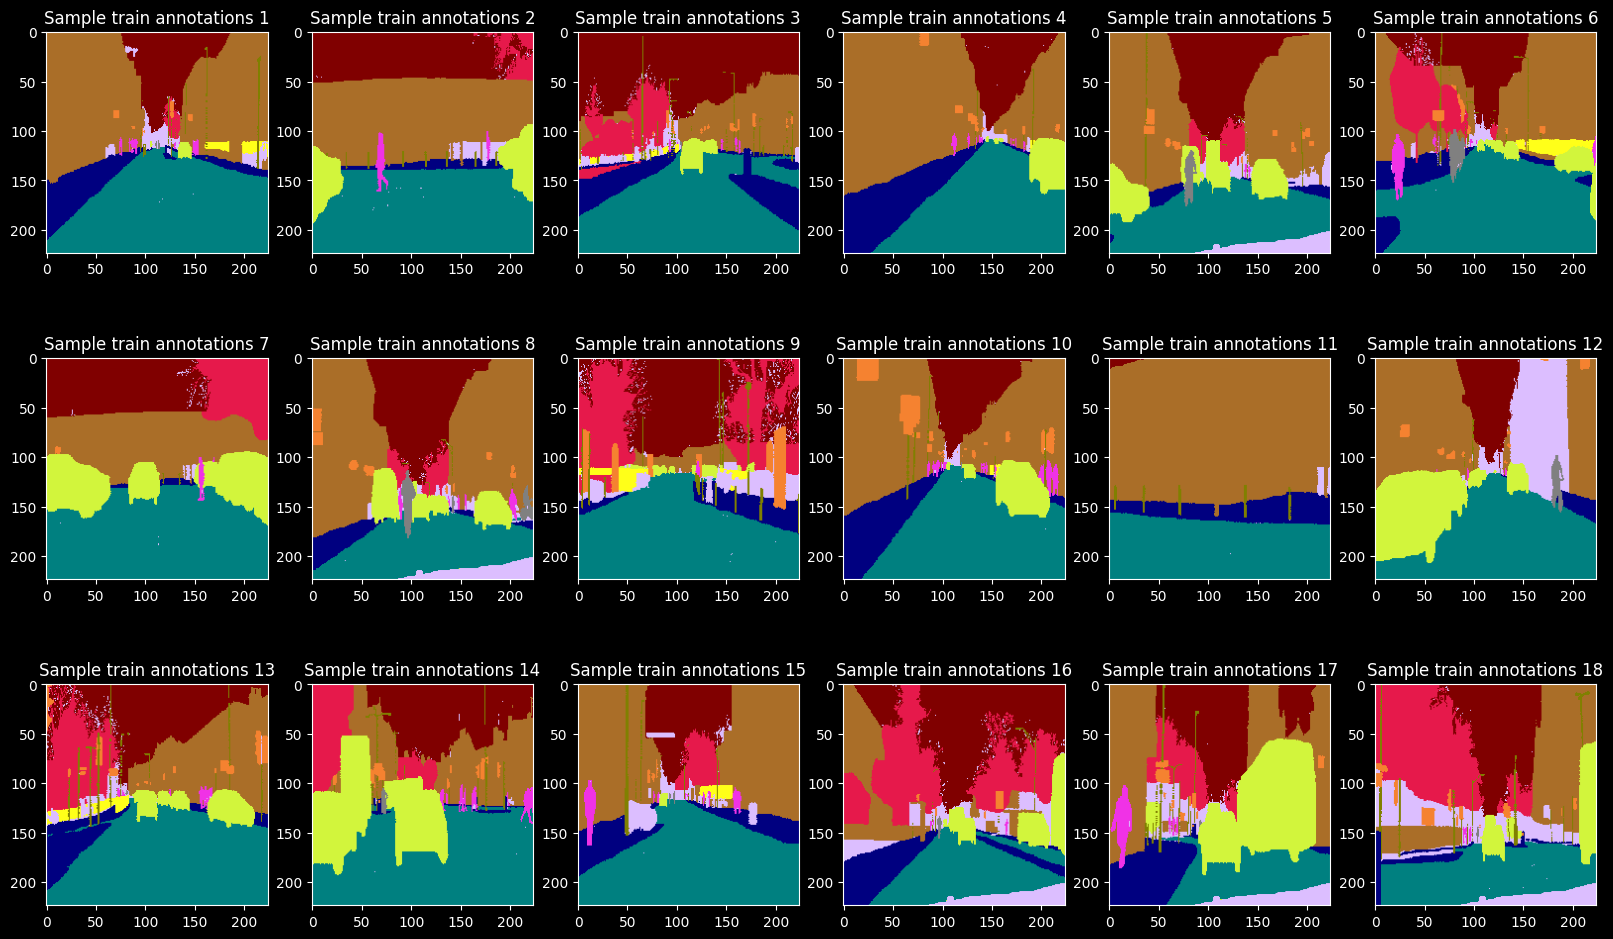

In [31]:
#Plot sample of train annotations
fig = plt.figure(figsize = (20,12))

for index in range(18):
    ax = fig.add_subplot(3,6,index+1)
    ax.set_title("Sample train annotations {}".format(index+1))
    ax.imshow(get_colored_segmentation_image(train_annotations[index],n_classes=12,colors=class_colors))

In [32]:
print("There are {} images in train images".format(len(os.listdir(img_path))))
print("\nThere are {} images in train annotations".format(len(os.listdir(annot_path))))
print("\nshape of one sample image in train images dataset: {}".format(train_images[0].shape))
print("\nshape of one sample image in train annotations dataset: {}".format(train_annotations[0].shape))

There are 367 images in train images

There are 367 images in train annotations

shape of one sample image in train images dataset: (224, 224, 3)

shape of one sample image in train annotations dataset: (224, 224, 3)


In [33]:
print("There are {} images in test images".format(len(os.listdir(img_path_test))))
print("\nThere are {} images in test annotations".format(len(os.listdir(annot_path_test))))
print("\nshape of one sample image in test images dataset: {}".format(test_images[0].shape))
print("\nshape of one sample image in test annotations dataset: {}".format(test_annotations[0].shape))

There are 101 images in test images

There are 101 images in test annotations

shape of one sample image in test images dataset: (224, 224, 3)

shape of one sample image in test annotations dataset: (224, 224, 3)


In [34]:
# change to RGB
train_x = []
test_x = []

train_x = changeToRGB(train_images_dir)
test_x = changeToRGB(test_images_dir)

In [35]:
print('train x', train_x.shape)
print('test x', test_x.shape)

train x (367, 224, 224, 3)
test x (101, 224, 224, 3)


In [36]:
train_y = []
test_y = []

train_y = np.array(train_annotations)[:,:,:,0]
test_y = np.array(test_annotations)[:,:,:,0]

np.unique(train_y), np.unique(test_y), train_y.shape, test_y.shape

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=uint8),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=uint8),
 (367, 224, 224),
 (101, 224, 224))

In [37]:
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)

train_y.shape, test_y.shape

((367, 224, 224, 12), (101, 224, 224, 12))

## Evaluation

#### Dice Loss

In [38]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_loss(y_true, y_pred, smooth=1):
    return 1.0 - (dice_coef(y_true, y_pred, smooth))

def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)

##Model and Training

#### FCN8 Model

In [39]:
def FCN8(image_size, ch_in=3, ch_out=12):
  inputs = Input(shape=(*image_size, ch_in), name='input')

  # Blok 1
  conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
  conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
  pool1 = MaxPooling2D(pool_size=(2,2))(conv1)

  # Blok 2
  conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
  pool2 = MaxPooling2D(pool_size=(2,2))(conv2)

  # Blok 3
  conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
  pool3 = MaxPooling2D(pool_size=(2,2))(conv3)

  # Blok 4
  conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
  pool4 = MaxPooling2D(pool_size=(2,2))(conv4)

  # Blok 5
  conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
  conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
  dropout5 = Dropout(0.5)(conv5) # Dropout is optional

  # Blok 6
  up6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(dropout5)
  merge6 = concatenate([conv4, up6], axis=3)
  conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
  conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

  # Block 7
  up7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
  merge7 = concatenate([conv3, up7], axis=3)
  conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
  conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

  # Block 8
  up8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
  merge8 = concatenate([conv2, up8], axis=3)
  conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
  conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

  # Block 9
  up9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
  merge9 = concatenate([conv1, up9], axis=3)
  conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
  conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

  # Final convolution layer
  conv10 = Conv2D(ch_out, 1, activation='softmax')(conv9)

  model = Model(inputs=inputs, outputs=conv10)

  return model

In [40]:
model_FCN8 = FCN8(image_size=(IMAGE_SIZE, IMAGE_SIZE))

In [41]:
model_FCN8.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  1792        ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 224, 224, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

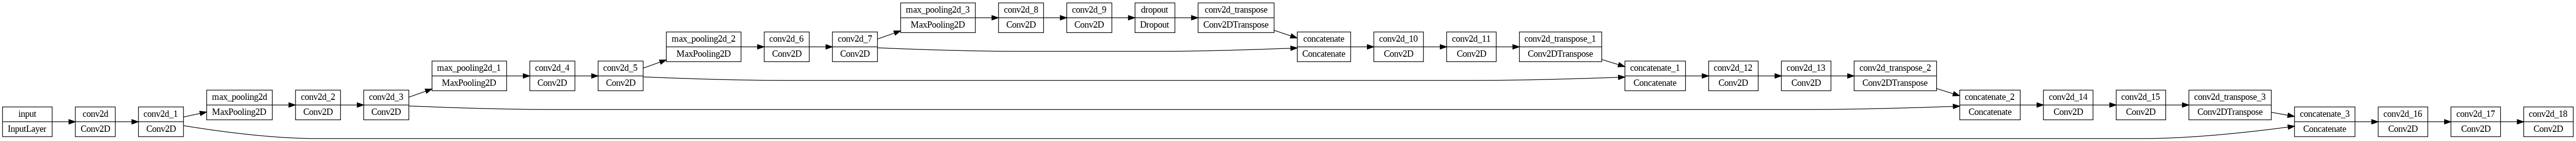

In [42]:
tf.keras.utils.plot_model(model_FCN8, rankdir='LR')

In [43]:
model_FCN8_checkpoint = keras.callbacks.ModelCheckpoint(filepath="/content/fcn8_model.h5",
                                                            verbose=1,
                                                            save_best_only=True,
                                                            save_weights_only=True)

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model_FCN8.compile(optimizer=Adam(1e-5, decay=1e-6), loss=dice_loss, metrics=[dice_coef, 'accuracy', 'binary_accuracy', true_positive_rate])

# Train model
history_fcn8 = model_FCN8.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=150, batch_size=4, callbacks=[model_FCN8_checkpoint, early_stopping])

Epoch 1/150
92/92 [==============================] - ETA: 0s - loss: 0.6991 - dice_coef: 0.3009 - accuracy: 0.3034 - binary_accuracy: 0.8866 - true_positive_rate: 0.2984
Epoch 1: val_loss improved from inf to 0.66584, saving model to /content/fcn8_model.h5
92/92 [==============================] - 48s 338ms/step - loss: 0.6991 - dice_coef: 0.3009 - accuracy: 0.3034 - binary_accuracy: 0.8866 - true_positive_rate: 0.2984 - val_loss: 0.6658 - val_dice_coef: 0.3341 - val_accuracy: 0.3568 - val_binary_accuracy: 0.8943 - val_true_positive_rate: 0.3421
Epoch 2/150
92/92 [==============================] - ETA: 0s - loss: 0.5667 - dice_coef: 0.4334 - accuracy: 0.4469 - binary_accuracy: 0.9088 - true_positive_rate: 0.4429
Epoch 2: val_loss improved from 0.66584 to 0.51898, saving model to /content/fcn8_model.h5
92/92 [==============================] - 24s 257ms/step - loss: 0.5667 - dice_coef: 0.4334 - accuracy: 0.4469 - binary_accuracy: 0.9088 - true_positive_rate: 0.4429 - val_loss: 0.5190 - va

##Plot Figure Training and Validation

#### Model FCN8

In [44]:
# Plot training and validation
acc = history_fcn8.history['accuracy']
val_acc = history_fcn8.history['val_accuracy']
loss = history_fcn8.history['loss']
val_loss = history_fcn8.history['val_loss']
dice = history_fcn8.history['dice_coef']
val_dice = history_fcn8.history['val_dice_coef']
bin_acc = history_fcn8.history['binary_accuracy']
val_bin_acc = history_fcn8.history['val_binary_accuracy']
tp_rate = history_fcn8.history['true_positive_rate']
val_tp_rate = history_fcn8.history['val_true_positive_rate']

epochs_range = history_fcn8.epoch

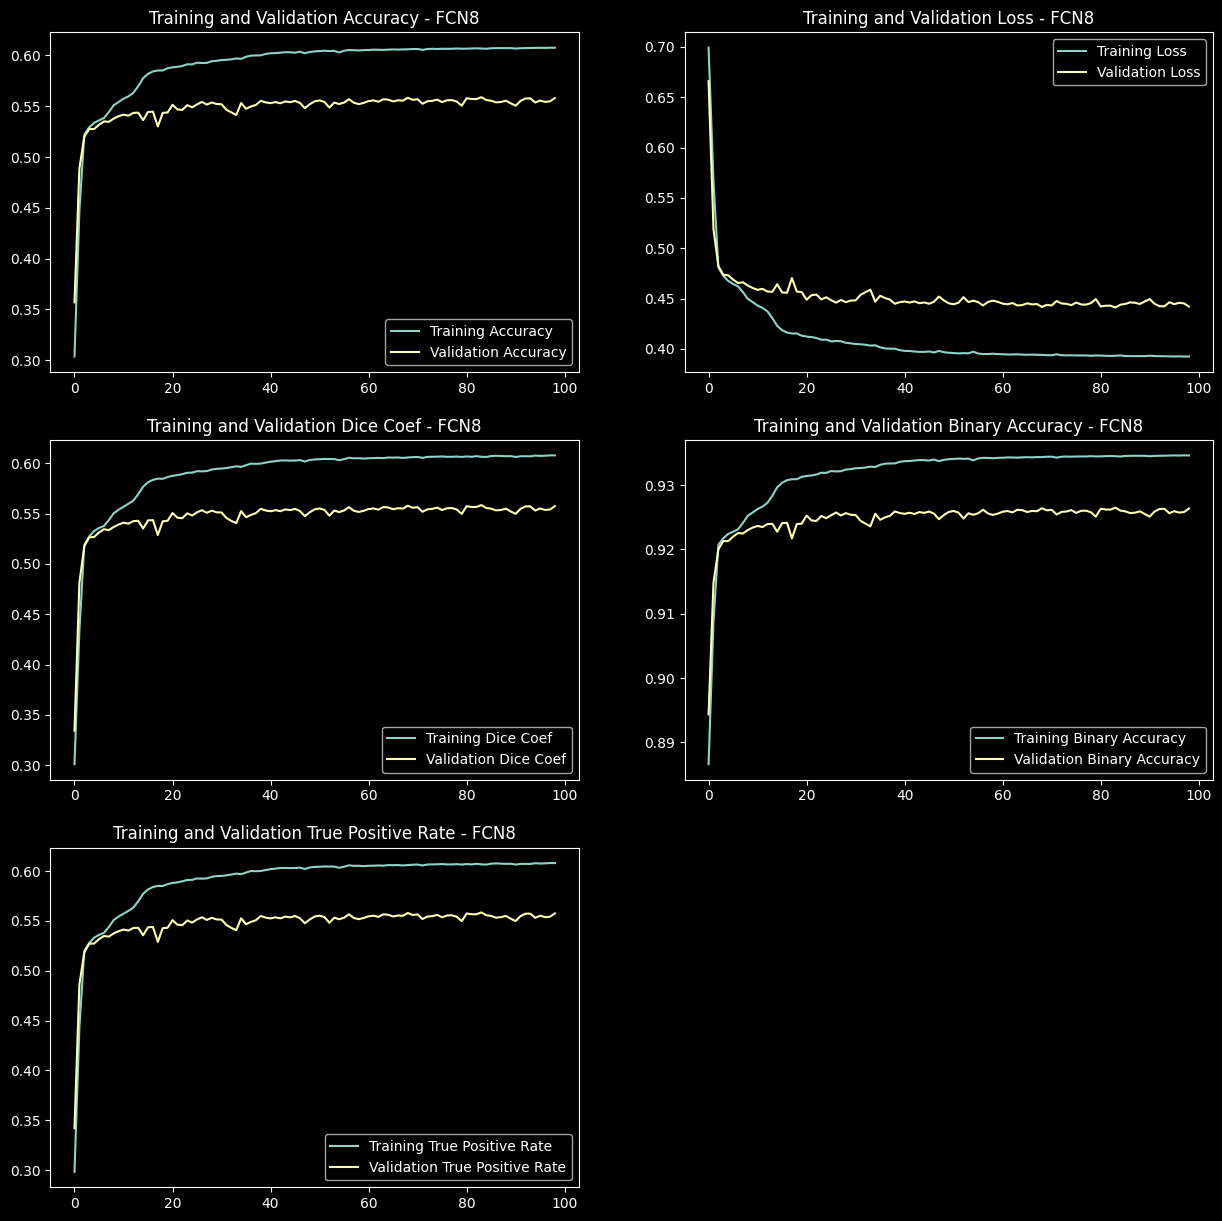

In [45]:
plt.figure(figsize=(15,15))
plt.subplot(3,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='best')
plt.title(f'Training and Validation Accuracy - FCN8')

plt.subplot(3,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.title(f'Training and Validation Loss - FCN8')

plt.subplot(3,2,3)
plt.plot(epochs_range, dice, label='Training Dice Coef')
plt.plot(epochs_range, val_dice, label='Validation Dice Coef')
plt.legend(loc='best')
plt.title(f'Training and Validation Dice Coef - FCN8')

plt.subplot(3,2,4)
plt.plot(epochs_range, bin_acc, label='Training Binary Accuracy')
plt.plot(epochs_range, val_bin_acc, label='Validation Binary Accuracy')
plt.legend(loc='best')
plt.title(f'Training and Validation Binary Accuracy - FCN8')

plt.subplot(3,2,5)
plt.plot(epochs_range, tp_rate, label='Training True Positive Rate')
plt.plot(epochs_range, val_tp_rate, label='Validation True Positive Rate')
plt.legend(loc='best')
plt.title(f'Training and Validation True Positive Rate - FCN8')
plt.show()

## Evaluation

In [46]:
pred_test_fcn8 = model_FCN8.predict(test_x)

4/4 [==============================] - 16s 1s/step


####Plot Predict FCN8

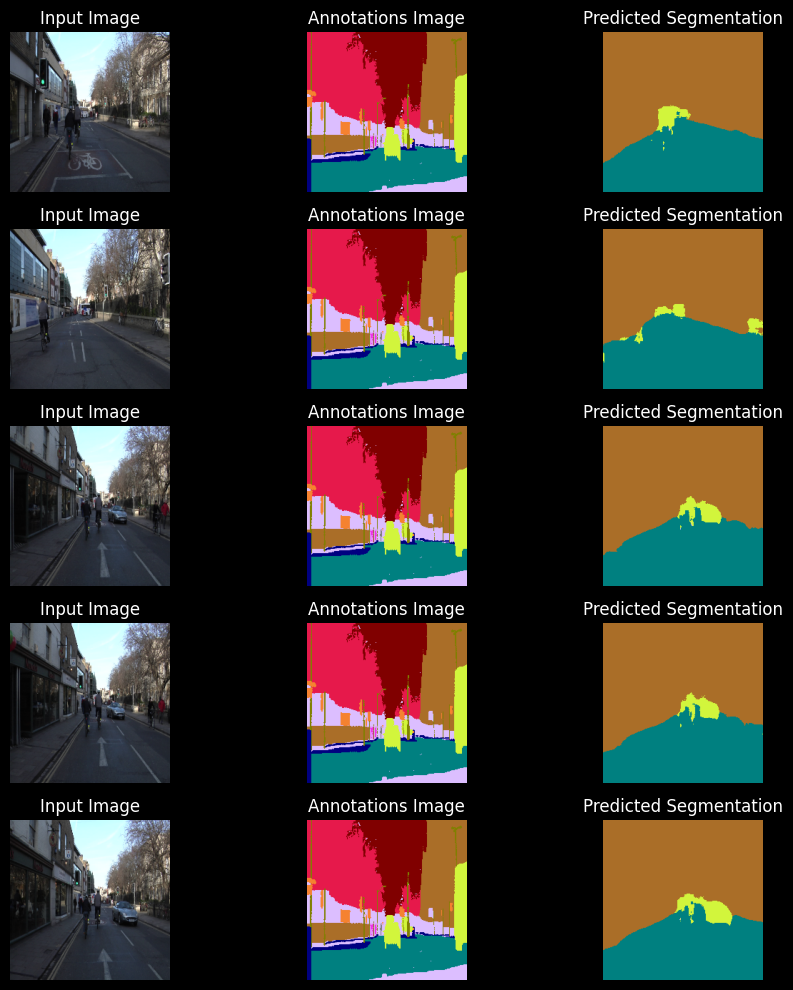

In [48]:
# Menampilkan beberapa contoh gambar prediksi segmentasi untuk model UNet
num_examples = 5  # Jumlah contoh gambar yang ingin ditampilkan
fig, axes = plt.subplots(num_examples, 3, figsize=(10, 10))

# Definisikan warna yang akan digunakan
colors = [[128,0,0], [170,110, 40], [128,128,0], [0,128,128], [0,0,128],
                [230,25,75], [245,130,48], [255,255,25], [210,245,60],
                [240,50,230], [128,128,128], [220,190,255], [255,215,180],
                [70,140,240], [0,130,200]]

for i in range(num_examples):
    # Menampilkan gambar asli
    axes[i, 0].imshow(test_x[i])
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Input Image')

    axes[i, 1].imshow(get_colored_segmentation_image(train_annotations[index],n_classes=12,colors=class_colors))
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Annotations Image')

    # Menampilkan gambar prediksi segmentasi
    pred_seg = np.argmax(pred_test_fcn8[i], axis=-1)  # Mengambil saluran dengan nilai maksimal sebagai prediksi segmentasi
    colored_pred_seg = np.zeros((pred_seg.shape[0], pred_seg.shape[1], 3), dtype=np.uint8)

    for j in range(pred_seg.shape[0]):
        for k in range(pred_seg.shape[1]):
            colored_pred_seg[j, k] = colors[pred_seg[j, k]]

    axes[i, 2].imshow(colored_pred_seg)
    axes[i, 2].axis('off')
    axes[i, 2].set_title('Predicted Segmentation')

plt.tight_layout()
plt.show()
